<a href="https://colab.research.google.com/github/tyemmett/portfolio/blob/main/OneWayANOVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Disclaimer:
The author created this notebook for personal, experimental, and testing purposes with a limited scope. The functionality has not been extensively validated. Use this code at your own risk, and verify its applicability to your specific use case.

## Project Description

This project focuses on implementing statistical methods and data analysis techniques using Python. The primary goal is to perform a one-way ANOVA to compare group means and identify significant differences between categories in a dataset. Additionally, the project incorporates post-hoc analysis with Tukey’s HSD test to provide detailed pairwise comparisons, along with clear visualizations and structured interpretations of the results.

The notebook includes dynamic features, such as:
- Dropdown menus for selecting variables to analyze.
- An adjustable alpha level slider for hypothesis testing.
- Customized, user-friendly output that dynamically adapts to the dataset's categories.

## Project Purpose

The purpose of this project is to:

1. **Demonstrate** the implementation of statistical analysis workflows in Python, suitable for use in exploratory data analysis or experimental research.
2. **Provide** a modular, interactive framework for hypothesis testing that can be applied to a variety of datasets.
3. **Facilitate learning** and experimentation with statistical methods by offering clear interpretations of results, including:
   - Null and alternative hypotheses.
   - Statistical outcomes and business implications.
4. **Offer a flexible tool** for researchers, analysts, or students to test and visualize group differences effectively.

This project serves as an educational tool and a demonstration of Python’s capabilities for statistical analysis. It encourages users to adapt and expand the framework for their own datasets and use cases.




Import Libraries and upload file

In [1]:
import pandas as pd
from google.colab import files
from io import BytesIO
import xml.etree.ElementTree as ET
import json
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, f_oneway
from IPython.display import display
import ipywidgets as widgets


# File upload
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Load data based on file type
if file_name.endswith('.csv'):
    data = pd.read_csv(BytesIO(uploaded[file_name]))
elif file_name.endswith('.xlsx'):
    data = pd.read_excel(BytesIO(uploaded[file_name]))
elif file_name.endswith('.txt'):
    data = pd.read_csv(BytesIO(uploaded[file_name]), delimiter='\t')  # adjust delimiter as needed
elif file_name.endswith('.xml'):
    tree = ET.parse(BytesIO(uploaded[file_name]))
    root = tree.getroot()
    data = pd.DataFrame([{elem.tag: elem.text for elem in record} for record in root])
elif file_name.endswith('.json'):
    with open(BytesIO(uploaded[file_name])) as f:
        json_data = json.load(f)
        data = pd.json_normalize(json_data)
else:
    raise ValueError("Unsupported file format. Please upload a CSV, Excel, TXT, XML, or JSON file.")

# Display the first few rows of the data
print("Data Preview:")
print(data.head())


Saving extended_test_anova_dataset.xlsx to extended_test_anova_dataset.xlsx
Data Preview:
  Region  StoreSize        Sales  CustomerSatisfaction  NumberOfEmployees
0   East          2  4005.892530              7.952669                 39
1   West          2  4780.290790              5.379699                 39
2  North          5  3730.974475              5.041454                 40
3   East          3  3766.265947              5.873857                 22
4   East          4  6630.090535              5.461750                 43


Automatic Variable Detection with Categorical Confirmation

In [2]:
# Initial variable detection
continuous_vars = []
categorical_vars = []
potential_categorical_numeric = {}

for column in data.columns:
    unique_values = data[column].nunique()
    if pd.api.types.is_numeric_dtype(data[column]):
        # Treat as continuous if many unique values, else flag as potential categorical
        if unique_values > 10:
            continuous_vars.append(column)
        else:
            potential_categorical_numeric[column] = unique_values
    else:
        categorical_vars.append(column)

# Display detected variables
print("Detected Continuous Variables:", continuous_vars)
print("Detected Categorical Variables:", categorical_vars)
print("Potential Numeric Categorical Variables:", potential_categorical_numeric)

# Confirm potential numeric categorical variables
for column, unique_count in potential_categorical_numeric.items():
    user_input = input(f"Should '{column}' with {unique_count} unique values be treated as categorical? (yes/no): ")

    if user_input.lower() == 'yes':
        categorical_vars.append(column)
        continuous_vars = [var for var in continuous_vars if var != column]

        # Map numeric values to descriptions if confirmed as categorical
        print(f"Please enter labels for each unique value in '{column}'")
        unique_values = data[column].unique()
        mapping = {}
        for value in unique_values:
            label = input(f"Label for {value}: ")
            mapping[value] = label
        data[column] = data[column].map(mapping)

    elif user_input.lower() == 'no':
        # Ask if it should be treated as continuous
        user_input_continuous = input(f"Should '{column}' be treated as continuous? (yes/no): ")

        if user_input_continuous.lower() == 'yes':
            continuous_vars.append(column)
            categorical_vars = [var for var in categorical_vars if var != column]
        else:
            # Ignore the variable if the user answers "no" again
            print(f"Variable '{column}' ignored.")


Detected Continuous Variables: ['Sales', 'CustomerSatisfaction', 'NumberOfEmployees']
Detected Categorical Variables: ['Region']
Potential Numeric Categorical Variables: {'StoreSize': 5}
Should 'StoreSize' with 5 unique values be treated as categorical? (yes/no): yes
Please enter labels for each unique value in 'StoreSize'
Label for 2: small
Label for 5: huge
Label for 3: reg
Label for 4: big
Label for 1: tiny


Dropdown Variable Selection, alpha level selection

In [3]:
# Dropdown for categorical variable selection
categorical_dropdown = widgets.Dropdown(
    options=categorical_vars,
    description='Categorical Var:',
    disabled=False,
)

# Dropdown for continuous variable selection
continuous_dropdown = widgets.Dropdown(
    options=continuous_vars,
    description='Continuous Var:',
    disabled=False,
)

# Text field for alpha level
alpha_slider = widgets.FloatSlider(
    value=0.05,
    min=0.01,
    max=0.2,
    step=0.01,
    description='Alpha Level:',
    continuous_update=False,
)
# Get slider value
alpha_level = alpha_slider.value

# Callback function to update alpha level dynamically
def on_alpha_change(change):
    global alpha_level
    alpha_level = change['new']  # Update alpha_level with the new slider value
    print(f"Alpha level updated to: {alpha_level}")

# Attach the callback to the slider
alpha_slider.observe(on_alpha_change, names='value')

# Display the widgets
display(categorical_dropdown, continuous_dropdown, alpha_slider)

# Confirm selection
print("Please select the categorical and continuous variables and adjust the alpha level above.")

Dropdown(description='Categorical Var:', options=('Region', 'StoreSize'), value='Region')

Dropdown(description='Continuous Var:', options=('Sales', 'CustomerSatisfaction', 'NumberOfEmployees'), value=…

FloatSlider(value=0.05, continuous_update=False, description='Alpha Level:', max=0.2, min=0.01, step=0.01)

Please select the categorical and continuous variables and adjust the alpha level above.


Data Validation Steps (Using Selected Variables)

In [4]:
# Capture dropdown selection values
categorical_column = categorical_dropdown.value
continuous_column = continuous_dropdown.value

# Check for missing values
if data[categorical_column].isnull().sum() > 0 or data[continuous_column].isnull().sum() > 0:
    print(f"\nMissing values detected in '{categorical_column}' or '{continuous_column}' columns.")
    user_input = input("Would you like to fill or drop missing values? Enter 'fill', 'drop', or 'skip': ").lower()

    if user_input == 'fill':
        fill_value = input("Enter a value to fill missing entries: ")
        data[categorical_column].fillna(fill_value, inplace=True)
        data[continuous_column].fillna(fill_value, inplace=True)
    elif user_input == 'drop':
        data.dropna(subset=[categorical_column, continuous_column], inplace=True)
    else:
        print("Skipping missing value handling.")
else:
    print("\nNo missing values detected.")

# Ensure adequate group size
group_sizes = data[categorical_column].value_counts()
small_groups = group_sizes[group_sizes < 2]
if not small_groups.empty:
    print("\nWarning: Some categories have fewer than 2 observations, which may affect ANOVA accuracy.")
    print("Small groups found:\n", small_groups)

# Ensure continuous variable is numeric
data[continuous_column] = pd.to_numeric(data[continuous_column], errors='coerce')
if data[continuous_column].isnull().any():
    print(f"\nNon-numeric values detected in '{continuous_column}' after conversion.")
    action = input("Would you like to drop or fill non-numeric entries? Enter 'drop', 'fill', or 'skip': ").lower()
    if action == 'fill':
        fill_value = float(input("Enter a numeric value to fill non-numeric entries: "))
        data[continuous_column].fillna(fill_value, inplace=True)
    elif action == 'drop':
        data.dropna(subset=[continuous_column], inplace=True)



No missing values detected.


Normality and Homogeneity Checks

In [5]:
#helper function to format p-values
def format_p_value(p_value, threshold=1e-5):
    if p_value < threshold:
        return "tiny"
    else:
        return f"{p_value:.5f}"

# Normality check (Shapiro-Wilk test)
print("\nNormality Check (Shapiro-Wilk test) for each group:")
normality_issues = False
for level in data[categorical_column].unique():
    group_data = data[data[categorical_column] == level][continuous_column]
    stat, p_value = shapiro(group_data)
    print(f"Group '{level}' - p-value: {format_p_value(p_value)}")
    if p_value < alpha_level:
        normality_issues = True

if normality_issues:
    print("Warning: Some groups do not meet the normality assumption for ANOVA.")

# Homogeneity of variance check (Levene's test)
stat, p_value = levene(*(data[data[categorical_column] == level][continuous_column]
                         for level in data[categorical_column].unique()))
print("\nLevene's Test for Homogeneity of Variance - p-value:", format_p_value(p_value))
if p_value < alpha_level:
    print("Warning: Variances across groups are significantly different. This may affect ANOVA validity.")
else:
    print("Variances across groups meet the homogeneity assumption.")




Normality Check (Shapiro-Wilk test) for each group:
Group 'small' - p-value: 0.06071
Group 'huge' - p-value: 0.44329
Group 'reg' - p-value: 0.07777
Group 'big' - p-value: 0.30719
Group 'tiny' - p-value: 0.94457

Levene's Test for Homogeneity of Variance - p-value: 0.96686
Variances across groups meet the homogeneity assumption.


Perform One-Way ANOVA and Tukey Test

=== Analysis Results ===
H₀: The means of CustomerSatisfaction for the categories small, huge, reg, big, tiny are equal.
H₁: At least one mean of CustomerSatisfaction among the categories small, huge, reg, big, tiny is significantly different.
Alpha Level: 0.05
F-Value: 0.9286
P-Value: 0.45078
Statistical Outcome: Fail to reject the null hypothesis.
Business Conclusion: There are no significant differences between the means of CustomerSatisfaction for the categories small, huge, reg, big, tiny.

Tukey's HSD Test Result:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   big   huge   0.5235 0.8223 -0.8393 1.8862  False
   big    reg   0.2461 0.9846 -1.0569 1.5492  False
   big  small  -0.1557 0.9969 -1.4135 1.1021  False
   big   tiny   0.5253 0.7603  -0.708 1.7585  False
  huge    reg  -0.2773 0.9797   -1.64 1.0854  False
  huge  small  -0.6792 0.6092 -1.9988 0.6404  False
  huge

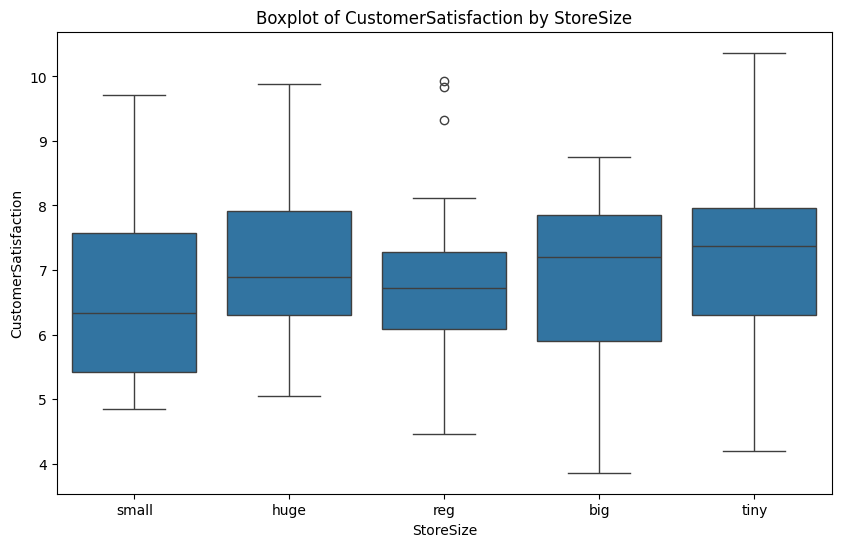

In [6]:
# Function to display detailed results
def display_analysis_results(alpha_level, f_stat, p_value, categories, continuous_var_name):
    # Null and alternative hypotheses
    null_hypothesis = f"H₀: The means of {continuous_var_name} for the categories {', '.join(categories)} are equal."
    alternative_hypothesis = f"H₁: At least one mean of {continuous_var_name} among the categories {', '.join(categories)} is significantly different."

    # Statistical outcome
    if p_value < alpha_level:
        statistical_outcome = "Reject the null hypothesis."
        business_conclusion = (
            f"There are significant differences between the means of {continuous_var_name} for the categories {', '.join(categories)}."
        )
    else:
        statistical_outcome = "Fail to reject the null hypothesis."
        business_conclusion = (
            f"There are no significant differences between the means of {continuous_var_name} for the categories {', '.join(categories)}."
        )

    # Display the results
    print("=== Analysis Results ===")
    print(null_hypothesis)
    print(alternative_hypothesis)
    print(f"Alpha Level: {alpha_level}")
    print(f"F-Value: {f_stat:.4f}")
    print(f"P-Value: {format_p_value(p_value)}")
    print(f"Statistical Outcome: {statistical_outcome}")
    print(f"Business Conclusion: {business_conclusion}")
    print("========================")

# Perform One-Way ANOVA
categories = data[categorical_column].unique()  # Get unique categories
anova_result = f_oneway(*(data[data[categorical_column] == level][continuous_column]
                          for level in categories))

# Display detailed ANOVA results
display_analysis_results(alpha_level, anova_result.statistic, anova_result.pvalue, categories, continuous_column)

# Perform Tukey's HSD Test
tukey_result = pairwise_tukeyhsd(data[continuous_column], data[categorical_column])
print("\nTukey's HSD Test Result:")
print(tukey_result)

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x=categorical_column, y=continuous_column, data=data)
plt.title(f"Boxplot of {continuous_column} by {categorical_column}")
plt.xlabel(categorical_column)
plt.ylabel(continuous_column)
plt.show()



In this cell I am trying to understand the difference between scipy and SAS in conducting a test for homogeneity of variance. This method is most similar to SAS.

In [7]:
squared_deviations = [(data[data[categorical_column] == level][continuous_column] -
                       data[data[categorical_column] == level][continuous_column].mean()) ** 2
                      for level in data[categorical_column].unique()]
anova_result = f_oneway(*squared_deviations)
print("ANOVA of Squared Deviations - F-statistic:", anova_result.statistic, "p-value:", format_p_value(anova_result.pvalue))


ANOVA of Squared Deviations - F-statistic: 0.04757217032769223 p-value: 0.99567
